In [1]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import scipy
import scipy.interpolate
from classy import Class

In [2]:
def get_omega_ncdm(h,m_ncdm,deg_ncdm,**kwargs):
    cs = Class()
    cs.set({'h':h,'N_ncdm':1,'m_ncdm':m_ncdm,'deg_ncdm':deg_ncdm})
    cs.set(kwargs)
    cs.compute()
    bg = cs.get_background()
    return h*h*bg['(.)rho_ncdm[0]'][-1]/bg['(.)rho_crit'][-1]

In [3]:
#kvec = [float('{:.2e}'.format(f)) for f in np.logspace(-6,0,500)]
kvec = [float("{:g}".format(kk)) for kk in np.logspace(-5,0,600)]
models = [0, 0.6] #[0, 0.15, 0.30, 0.6, 1.2]
cosmo = {}
for key in models:
    lmax_g = 600
    lmax_pol = 20
    lmax_ncdm = 20
    lmax_ur = 20
    omega_cdmnu = 0.1197
    cosmo[key] = Class()
    cosmo[key].set(
        {'output':'mPk, dTk, vTk', 
          'radiation_streaming_approximation':3,
          'omega_b':0.02222,
          'h':0.6731,
          'tau_reio':0.078,
          'n_s':0.9655,
          'k_output_values':str(kvec).strip('[]'),
          'l_max_g':lmax_g, 
          'l_max_pol_g':lmax_pol,
        'gauge':'Synchronous',
        'recfast_Nz0':100000,
          'tol_thermo_integration':1e-5,
        'z_pk':'101.,0.',
        'P_k_max_1/Mpc':50,})
    if key==0:
        cosmo[key].set(
            {'omega_cdm':0.1197,
              'l_max_ur':lmax_ur,
            'ur_fluid_approximation':2})
    else:
        params = cosmo[key].pars
        
        omega_ncdm = get_omega_ncdm(params['h'],key/3.,3.0)
        print key, omega_ncdm
        cosmo[key].set(
            {'omega_cdm':omega_cdmnu-omega_ncdm,
             'N_ncdm':1,
             'm_ncdm':key/3.,
             'deg_ncdm':3.0,
            'N_ur':0.,
            'ncdm_fluid_approximation':3})
    cosmo[key].compute()

0.6 0.006441715919587556


In [4]:
def get_transfer_from_pt(a, pt, key):
    tk = []
    for pts in pt:
        tkval = np.interp(a,pts['a'],pts[key])
        tk.append(tkval)
    return np.array(tk)

def get_transfer_and_derivative_from_pt(a, pt, key):
    tk = []
    tk_prime = []
    for pts in pt:
        y_prime = np.gradient(pts[key],pts['tau [Mpc]'])
        tkval = np.interp(a,pts['a'],pts[key])
        tkval_prime = np.interp(a,pts['a'],y_prime)
        tk.append(tkval)
        tk_prime.append(tkval_prime)
    return np.array(tk), np.array(tk_prime)

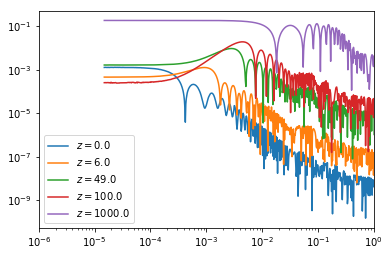

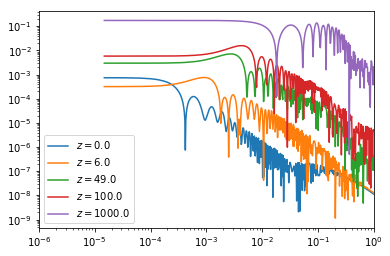

In [5]:
for key in models:
    plt.figure()
    pt = cosmo[key].get_perturbations()['scalar']
    z = np.array([0., 6.,49.,100.,1000.])
    k = np.array(kvec)
    a = 1./(1+z)
    phi = get_transfer_from_pt(a, pt, 'phi')
    psi = get_transfer_from_pt(a, pt, 'psi')
    H_T_Nb_prime, H_T_Nb_prime_prime = get_transfer_and_derivative_from_pt(a, pt, 'H_T_Nb_prime')

    for i, zz in enumerate(z):
        H = cosmo[key].Hubble(zz)
        gamma = -(H_T_Nb_prime_prime[:,i]+a[i]*H*H_T_Nb_prime[:,i])/k/k+(phi[:,i]-psi[:,i])
        plt.loglog(k/cosmo[key].h(),np.abs(gamma/phi[:,i]),label=r'$z = '+str(zz)+'$')

    plt.legend()
    plt.xlim([1e-6,1e0])
    fname = 'gamma_ratio_M'+str(key)+'.pdf'
    plt.savefig(fname,bbox_inches='tight')

In [6]:
z_out = np.arange(500,-1,-1)
k = np.array(kvec)
a = 1./(1+z_out)

for key in models:
    TF = np.zeros((len(z_out),len(k)))
    TF_g = np.zeros((len(z_out),len(k)))
    TF_nu = np.zeros((len(z_out),len(k)))
    TF_gamma = np.zeros((len(z_out),len(k)))
    TF_fake_delta = np.zeros((len(z_out),len(k)))
    TF_fake_delta_old = np.zeros((len(z_out),len(k)))
    # Bacground stuff
    bg = cosmo[key].get_background()
    bgkeys = bg.keys()
    has_ur = True if '(.)rho_ur' in bgkeys else False
    has_ncdm = True if '(.)rho_ncdm[0]' in bgkeys else False

    rho_cdm = np.interp(a, 1./(1+bg['z']), bg['(.)rho_cdm'])
    rho_crit = np.interp(a, 1./(1+bg['z']), bg['(.)rho_crit'])
    rho_crit_today = bg['(.)rho_crit'][-1]
    
    rho_b = np.interp(a, 1./(1+bg['z']), bg['(.)rho_b'])
    rho_g = np.interp(a, 1./(1+bg['z']), bg['(.)rho_g'])
    rho_rad = np.interp(a, 1./(1+bg['z']), bg['(.)rho_g'])
    rho_plus_p_tot = rho_b+rho_cdm+4./3.*rho_g
    if has_ur:
        rho_ur = np.interp(a, 1./(1+bg['z']), bg['(.)rho_ur'])
        rho_rad += rho_ur
        rho_plus_p_tot += 4./3.*rho_ur
    if has_ncdm:
        rho_ncdm = np.interp(a, 1./(1+bg['z']), bg['(.)rho_ncdm[0]'])
        p_ncdm = np.interp(a, 1./(1+bg['z']), bg['(.)p_ncdm[0]'])
        rho_rad += rho_ncdm
        rho_plus_p_tot += (rho_ncdm+p_ncdm)

    # Perturbations / transfer functions
    pt = cosmo[key].get_perturbations()['scalar']
    phi = get_transfer_from_pt(a, pt, 'phi')
    psi = get_transfer_from_pt(a, pt, 'psi')
    delta_cdm = get_transfer_from_pt(a, pt, 'delta_cdm')
    theta_cdm = get_transfer_from_pt(a, pt, 'theta_cdm')
    theta_b = get_transfer_from_pt(a, pt, 'theta_b')
    delta_g = get_transfer_from_pt(a, pt, 'delta_g')
    theta_g = get_transfer_from_pt(a, pt, 'theta_g')
    
    if has_ur:
        delta_ur = get_transfer_from_pt(a, pt, 'delta_ur')
        theta_ur = get_transfer_from_pt(a, pt, 'theta_ur')
    if has_ncdm:
        delta_ncdm = get_transfer_from_pt(a, pt, 'delta_ncdm[0]')
        theta_ncdm = get_transfer_from_pt(a, pt, 'theta_ncdm[0]')
        
    H_T_Nb_prime, H_T_Nb_prime_prime = get_transfer_and_derivative_from_pt(a, pt, 'H_T_Nb_prime')
    
    for i, zz in enumerate(z_out):
        H = cosmo[key].Hubble(zz)
        gamma = -(H_T_Nb_prime_prime[:,i]+a[i]*H*H_T_Nb_prime[:,i])/k/k+(phi[:,i]-psi[:,i])
        rho_plus_p_theta_tot = rho_cdm[i]*theta_cdm[:,i]+rho_b[i]*theta_b[:,i]
        # Photons
        drho_g = rho_g[i]*delta_g[:,i]
        rho_plus_p_theta_tot += 4./3.*rho_g[i]*theta_g[:,i]
        # ur
        if has_ur:
            drho_ur = rho_ur[i]*delta_ur[:,i]
            rho_plus_p_theta_tot += 4./3.*rho_ur[i]*theta_ur[:,i]
        if has_ncdm:
            drho_ncdm = rho_ncdm[i]*delta_ncdm[:,i]
            rho_plus_p_theta_tot += (rho_ncdm[i]+p_ncdm[i])*theta_ncdm[:,i]
        theta_tot = rho_plus_p_theta_tot/rho_plus_p_tot[i]
        
        drho_cdm = rho_cdm[i]*delta_cdm[:,i]
        phi_cdm = -1.5*a[i]*a[i]*drho_cdm/k/k-4.5*a[i]**3*H/k**4*rho_cdm[i]*theta_tot
        phi_g = -1.5*a[i]**2*drho_g/k/k-4.5*a[i]**3*H/k**4*4./3.*rho_g[i]*theta_tot
        # ur
        if has_ur:
            phi_ur = -1.5*a[i]**2*drho_ur/k/k-4.5*a[i]**3*H/k**4*4./3.*rho_ur[i]*theta_tot
        else:
            phi_ur = 0
        if has_ncdm:
            phi_ncdm = -1.5*a[i]**2*drho_ncdm/k/k-4.5*a[i]**3*H/k**4*(rho_ncdm[i]+p_ncdm[i])*theta_tot
        else:
            phi_ncdm = 0
        
        # Sign comes from sign difference in capital Phi and small phi
        total_force = -gamma+phi_g+phi_ur+phi_ncdm
        TF[i,:] = total_force
#        TF_fake_delta[i,:] = 2./3.*total_force/(a[i]*a[i]*rho_cdm[i])
        TF_fake_delta_old[i,:] = 2./3.*total_force/(a[i]*a[i]*rho_rad[i])
        TF_fake_delta[i,:] = 2./3.*total_force/(a[i]*a[i]*rho_crit_today)
        #TF_g[i,:] = phi_g[:,i]
        #TF_nu[i,:] = phi_ur+phi_ncdm
        TF_gamma[i,:] = gamma
        
    np.savetxt('average_force_potential_M'+str(key)+'.dat',TF)
    np.savetxt('average_force_fake_delta_M'+str(key)+'.dat',TF_fake_delta)
    np.savetxt('average_force_fake_delta_M'+str(key)+'_old.dat',TF_fake_delta_old)
        